In [25]:
import itertools
import os
import re
import sys

import pandas as pd
import numpy as np
import scipy as sp

from sharknado.scipy.lib.data_manipulation import shark
from sharknado.scipy.transformers import signature
from sklearn.externals import joblib

%matplotlib inline
from IPython.core.pylabtools import figsize
from IPython.display import clear_output
from seaborn import plt

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

## Read in and run existing model on sample data

In [117]:
model_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
m = models.load_model(os.path.join(
    model_dir,
    "em8_ch32_ba32_ep20_bpe200_sw125_20161207183706_interrupted.model"))

In [118]:
def Scrub(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([s.upper()]).toarray()
    starts, stops = m.predict(encoded)
    return s[starts.argmax():stops.argmax()]

def ScrubBatch(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([ss.upper() for ss in s]).toarray()
    starts, stops = m.predict(encoded)
    return [
        ss[start:stop].upper()
        for ss, start, stop
        in zip(s, starts.argmax(1), stops.argmax(1))]

In [119]:
ugly = shark.Query("""
SELECT merchant
FROM transactions
ORDER BY clear_date DESC
LIMIT 20000
""")

Querying sharknado at http://ec2-107-20-123-161.compute-1.amazonaws.com:4043


In [122]:
def GetPredictions(m, s):
    v = bf.CharacterVectorizer()
    encoded = v.transform([s.upper()]).toarray()
    starts, stops = m.predict(encoded)
    return starts, stops

def Visualize(m, s):
    starts, stops = GetPredictions(m, s)
    slen = max(len(s), 50)
    x = np.arange(slen)
    figsize(12, 1.5)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x, starts[0][:slen], color="green", alpha=0.5)
    ax.bar(x, stops[0][:slen], color="red", alpha=0.5)
    plt.xticks(x + 0.3, s.upper())
    plt.xlim(0, slen)
    plt.title("Model Predoctions of Merchant Start and End")
    ax.set_yticklabels([])
    plt.show()

In [ ]:
cv = bf.CharacterVectorizer()
u_starts, u_stops = m.predict(cv.transform(ugly.merchant).toarray())

In [ ]:
ugly["entropy"] = (
    sp.special.entr(u_starts).sum(axis=1) + sp.special.entr(u_stops).sum(axis=1) / np.log(2))

In [ ]:
ugly["confidence"] = u_starts.max(axis=1) * u_stops.max(axis=1)

In [ ]:
figsize(16, 6)
plt.hist(ugly.entropy, bins=np.arange(0, 5, 0.1), histtype="stepfilled", alpha=0.7)
plt.title("Distribution of Start and Stop Index Entropy")
plt.ylabel("Count")
plt.xlabel("H(start) + H(stop)")
plt.show()

plt.hist(ugly.confidence, bins=np.arange(0, 1, 0.01), histtype="stepfilled", alpha=0.7)
plt.title("Distribution of Slice Confidence")
plt.ylabel("Count")
plt.xlabel("P(start) * P(stop)")
plt.show()

plt.title("Entropy vs. Confidence")
plt.scatter(ugly.entropy, ugly.confidence, alpha=0.05)
plt.xlim(0, 5)
plt.ylim(0, 1)
plt.xlabel("Entropy")
plt.ylabel("Confidence")
plt.show()

## Fine Tuning
### Create Fine Tuning Dataset

In [381]:
def RankSlices(m, s):
    starts, stops = [p[0] for p in GetPredictions(m, s)]
    ranked_starts, ranked_stops = [p.argsort()[::-1][:5] for p in (starts, stops)]
    options = []
    for srt_ix, stp_ix in itertools.product(ranked_starts, ranked_stops):
        if srt_ix < stp_ix:
            prob = starts[srt_ix] * stops[stp_ix]
            if prob > 0.0001:
                options.append((prob, srt_ix, stp_ix, s[srt_ix:stp_ix]))
    return list(sorted(options, reverse=True))

In [357]:
candidates = ugly.sort_values("entropy", ascending=False).merchant.unique()

In [440]:
num_re = re.compile(r"[0-9]+")
candidate_sigs = set()
keep = []
for cnd in candidates:
    sig = num_re.sub("0", cnd)
    if sig in candidate_sigs:
        continue
    else:
        candidate_sigs.add(sig)
        keep.append(cnd)
keep = np.array(keep)

In [453]:
def AnnotateOne(m, s):
    ranked = RankSlices(m, s)
    i = 0
    while i < len(ranked):
        prob, srt_ix, stp_ix, substr = ranked[i]
        print "> " + s
        print "? " + " " * srt_ix + substr
        sys.stdout.flush()
        take_input = True
        while take_input:
            inp = raw_input()
            if inp == ";":
                clear_output()
                print "> " + s
                print "= " + " " * srt_ix + substr
                return substr
            elif inp.startswith("+"):
                clear_output()
                substr = inp.strip("+").strip()
                print "> " + s
                print "= " + substr
                return substr
            elif inp == "k":
                clear_output()
                substr = s
                print "> " + s
                print "= " + substr
                return substr
            elif inp == "'":
                clear_output()
                take_input = False
                i += 1
            elif inp == "b":
                clear_output()
                take_input = False
                i -= 1
            elif inp == "q":
                clear_output()
                return "QQQQ"
            else:
                sys.stdout.write("what?")
    print "? " + s
    print "?" * (len(s) + 2)

In [454]:
def AnnotateMany(m, ss, data_dir=os.path.join(os.path.dirname(os.getcwd()), "data", "raw")):
    with open(os.path.join(data_dir, "hand_annotated.tsv"), "r") as f:
        already_annotated = set([line.partition("\t")[0] for line in f.readlines()])
    for s in ss:
        if s in already_annotated:
            continue
        substr = AnnotateOne(m, s)
        if substr == "QQQQ":
            return
        elif substr is not None:
            with open(os.path.join(data_dir, "hand_annotated.tsv"), "a") as f:
                f.write("{}\t{}\n".format(s, substr))

In [455]:
AnnotateMany(m, keep)

### Evaluate & Train on Fine Tuning Data

In [543]:
m2 = models.load_model(os.path.join(
    model_dir,
    "em8_ch32_ba32_ep5_20161120061601.model"))

In [476]:
annotated_path = os.path.join(
    os.path.dirname(os.getcwd()),
    "data", "raw", "hand_annotated.tsv")
with open(annotated_path, "r") as f:
    annotated = [line.strip().split("\t") for line in f.readlines()]

In [509]:
ha_starts = np.array([s.index(mer) for s, mer in annotated])
ha_stops = np.array([min(s + len(mer), 124) for s, (_, mer) in zip(ha_starts, annotated)])

def onehot(ixs):
    hot = np.zeros((ixs.shape[0], 125))
    hot[np.arange(ixs.shape[0]), ixs] = 1
    return hot

ha_starts = onehot(ha_starts)
ha_stops = onehot(ha_stops)

In [510]:
ha_merchants = cv.transform([s for s, _ in annotated]).toarray()

In [517]:
ha_ixs = np.arange(ha_starts.shape[0])
np.random.shuffle(ha_ixs)

ha_starts_train = ha_starts[ha_ixs[500:]]
ha_stops_train = ha_stops[ha_ixs[500:]]
ha_merchants_train = ha_merchants[ha_ixs[500:]]

ha_starts_test = ha_starts[ha_ixs[:500]]
ha_stops_test = ha_stops[ha_ixs[:500]]
ha_merchants_test = ha_merchants[ha_ixs[:500]]

In [531]:
m2.fit(
    ha_merchants_train,
    [ha_starts_train, ha_stops_train],
    batch_size=32,
    nb_epoch=5,
    verbose=1,
    validation_data=(
        ha_merchants_test,
        [ha_starts_test, ha_stops_test]),
    shuffle=True)

Train on 2593 samples, validate on 500 samples
Epoch 1/5
2593/2593 [==============================] - 213s - loss: 1.0804 - start_index_loss: 0.3639 - end_index_loss: 0.7165 - start_index_acc: 0.8735 - end_index_acc: 0.7385 - val_loss: 1.3187 - val_start_index_loss: 0.4230 - val_end_index_loss: 0.8957 - val_start_index_acc: 0.8560 - val_end_index_acc: 0.6600
Epoch 2/5
2593/2593 [==============================] - 234s - loss: 0.8434 - start_index_loss: 0.2398 - end_index_loss: 0.6036 - start_index_acc: 0.9194 - end_index_acc: 0.7759 - val_loss: 1.3370 - val_start_index_loss: 0.4413 - val_end_index_loss: 0.8957 - val_start_index_acc: 0.8500 - val_end_index_acc: 0.6740
Epoch 3/5
 256/2593 [=>............................] - ETA: 188s - loss: 0.6616 - start_index_loss: 0.1654 - end_index_loss: 0.4961 - start_index_acc: 0.9453 - end_index_acc: 0.8438

KeyboardInterrupt: 

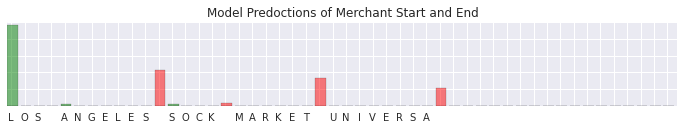

In [532]:
Visualize(m2, "LOS ANGELES SOCK MARKET UNIVERSA")

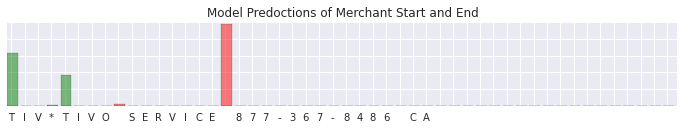

In [533]:
Visualize(m2, "TIV*TIVO SERVICE 877-367-8486 CA")

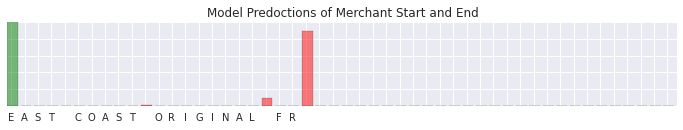

In [534]:
Visualize(m2, "East Coast Original Fr")

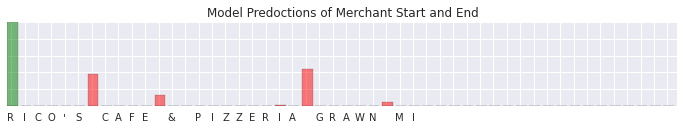

In [535]:
Visualize(m2, "RICO'S CAFE & PIZZERIA GRAWN MI")

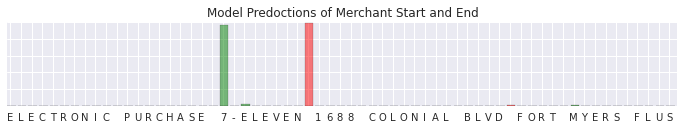

In [536]:
Visualize(m2, "Electronic Purchase 7-ELEVEN 1688 COLONIAL BLVD FORT MYERS FLUS")

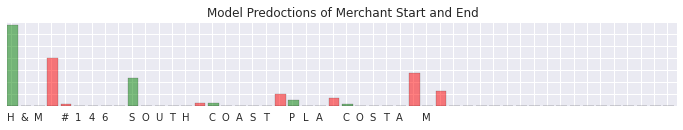

In [537]:
Visualize(m2, "H&M #146 SOUTH COAST PLA COSTA M")

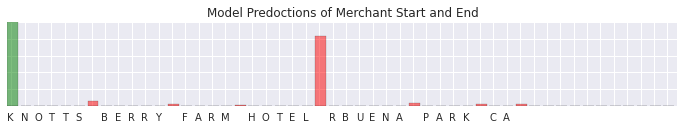

In [538]:
Visualize(m2, "KNOTTS BERRY FARM HOTEL RBUENA PARK CA")

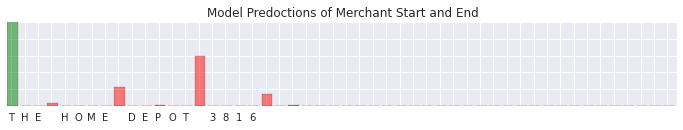

In [539]:
Visualize(m2, "The HOME DEPOT 3816")

In [84]:
Visualize(m2, "CHECKCARD 0110 LA BICYCLETTE CARMEL CA")

NameError: name 'm2' is not defined

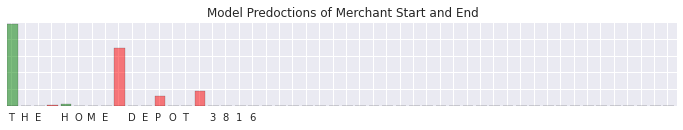

In [86]:
Visualize(m, "The HOME DEPOT 3816")

In [87]:
pd.read_csv("../reports/history_em8_ch32_ba32_ep5_20161120061601.csv")

,end_index_acc,end_index_loss,loss,start_index_acc,start_index_loss,val_end_index_acc,val_end_index_loss,val_loss,val_start_index_acc,val_start_index_loss
0,0.947373,0.167881,0.271640,0.971490,0.103759,0.959214,0.126407,0.188824,0.983973,0.062417
1,0.962698,0.117482,0.173473,0.984620,0.055991,0.962833,0.112422,0.165388,0.986386,0.052966
2,0.967466,0.101760,0.144602,0.988088,0.042842,0.966797,0.099270,0.145179,0.987764,0.045909
3,0.971139,0.090260,0.124836,0.990132,0.034577,0.969439,0.092383,0.139758,0.987994,0.047375
4,0.974208,0.080798,0.109866,0.991589,0.029068,0.970186,0.090926,0.133719,0.988856,0.042793
